In [11]:
!pip install torchvision

In [12]:
import torch
import torchvision
import torchvision.transforms.v2 as T


toTensor = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale = True)])

train_and_valid_data = torchvision.datasets.FashionMNIST(
    root = "datasets", train = True, download = True,
    transform = toTensor
)

test_data = torchvision.datasets.FashionMNIST(root = "datasets",
                                             train = False, download = True,
                                             transform = toTensor)

torch.manual_seed(42)
train_data, valid_data = torch.utils.data.random_split(
    train_and_valid_data, [55_000, 5_000]
)

# Image is a subclass of tensor which will change the dataset into 3 dimension 

In [13]:
from torch.utils.data import TensorDataset, DataLoader

train_loader = DataLoader(train_data, batch_size = 32, shuffle = True,
                         num_workers=0,
                         pin_memory=True)
valid_loader = DataLoader(valid_data, batch_size = 32, shuffle=True,
                         num_workers=0,
                         pin_memory=True)
test_loader = DataLoader(test_data, batch_size = 32)

In [14]:
X_sample, y_sample = train_data[0]
X_sample.shape

# Here the image converted into 3 dimension as 1st as color dimension which is 1 because of greyscale image
# the second and third are height and width

torch.Size([1, 28, 28])

In [15]:
X_sample.dtype

torch.float32

In [16]:
train_and_valid_data.classes[y_sample]

'Ankle boot'

In [17]:
import torch.nn as nn

class ImageClassifier(nn.Module):

    def __init__(self, n_inputs, n_hidden1, n_hidden2, n_classes):

        super().__init__()

        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_inputs, n_hidden1),
            nn.ReLU(),
            nn.Linear(n_hidden1, n_hidden2),
            nn.ReLU(),
            nn.Linear(n_hidden2, n_classes)
        )

    def forward(self, X):
        return self.mlp(X)

# Flatten would change the image into size 28 x 28 as 784

In [18]:
torch.manual_seed(42)
model = ImageClassifier(n_inputs = 28 * 28, n_hidden1 = 300, n_hidden2 = 100, n_classes = 10)

xentropy = nn.CrossEntropyLoss()

In [19]:
device = 'cuda'
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
model.to(device)

for epoch in range(20):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = xentropy(logits, y_batch)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}, Loss: {loss.item():.3f}")


Epoch 1, Loss: 0.584
Epoch 2, Loss: 0.478
Epoch 3, Loss: 0.507
Epoch 4, Loss: 0.266
Epoch 5, Loss: 0.346
Epoch 6, Loss: 0.671
Epoch 7, Loss: 0.687
Epoch 8, Loss: 0.474
Epoch 9, Loss: 0.391
Epoch 10, Loss: 0.718
Epoch 11, Loss: 0.608
Epoch 12, Loss: 0.278
Epoch 13, Loss: 0.089
Epoch 14, Loss: 0.197
Epoch 15, Loss: 0.290
Epoch 16, Loss: 0.209
Epoch 17, Loss: 0.171
Epoch 18, Loss: 0.397
Epoch 19, Loss: 0.161
Epoch 20, Loss: 0.292


In [20]:
import torchmetrics

accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(device)

In [21]:
accuracy

MulticlassAccuracy()

In [22]:
model.eval()

X_new, y_new = next(iter(valid_loader))
device = next(model.parameters()).device
X_new = X_new[:5].to(device)

In [23]:
with torch.no_grad():
    y_pred_logits = model(X_new)

y_pred = y_pred_logits.argmax(dim=1)
y_pred

tensor([9, 4, 2, 5, 9], device='cuda:0')

In [24]:
[train_and_valid_data.classes[index] for index in y_pred]

['Ankle boot', 'Coat', 'Pullover', 'Sandal', 'Ankle boot']

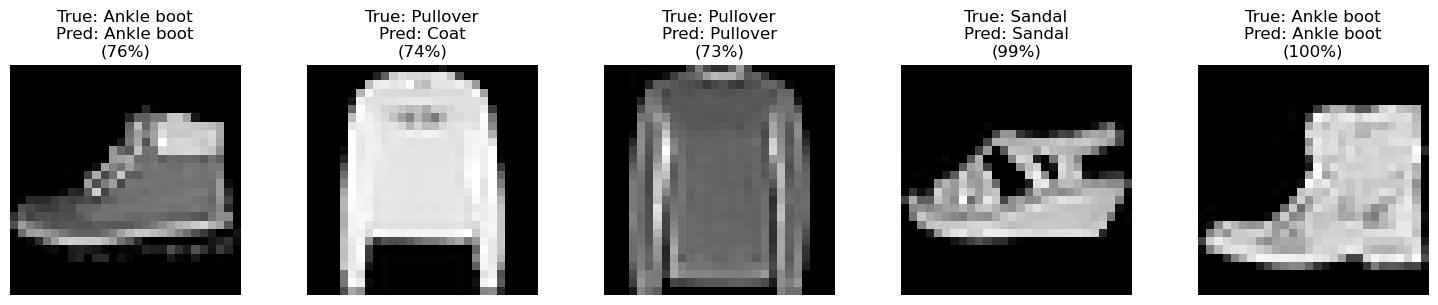

In [55]:
import matplotlib.pyplot as plt
import torch.nn.functional as F


class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
model.eval()

with torch.no_grad():
    for i in range(5):
        img = X_new[i]
        logit = model(img.cpu().unsqueeze(0).to(device))
        pred = logit.argmax(1).item()
        prob = F.softmax(logit, dim=1).max().item()
        
        axs[i].imshow(img.cpu().squeeze(), cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(f'True: {class_names[y_new[i]]}\nPred: {class_names[pred]}\n({prob:.0%})')

plt.tight_layout()
plt.show()

In [29]:
import torch.nn.functional as F

y_proba = F.softmax(y_pred_logits, dim = 1)
y_proba

# F.softmax function will give the softmax probability for an image related to every class

tensor([[6.9603e-04, 7.6958e-05, 2.4935e-05, 3.1684e-05, 4.9952e-06, 9.4016e-02,
         1.9690e-04, 1.4770e-01, 1.9577e-03, 7.5529e-01],
        [3.4107e-05, 1.5008e-05, 2.1640e-01, 1.8095e-05, 7.3916e-01, 2.3849e-08,
         4.3370e-02, 7.3199e-11, 1.0032e-03, 7.5114e-12],
        [4.5032e-03, 6.3232e-05, 7.2505e-01, 2.2377e-04, 3.3022e-02, 4.5973e-07,
         2.3621e-01, 2.5975e-09, 9.2974e-04, 7.9921e-09],
        [4.2444e-05, 3.2204e-06, 7.0129e-06, 3.4864e-06, 5.1029e-06, 9.9301e-01,
         3.1904e-05, 1.8779e-03, 4.5083e-03, 5.1504e-04],
        [1.1916e-07, 7.8373e-09, 4.6721e-10, 1.2145e-10, 2.5729e-11, 7.8403e-05,
         3.6223e-09, 2.7415e-04, 1.7011e-06, 9.9965e-01]], device='cuda:0')

In [30]:
y_top3_logits, y_top3_indices = torch.topk(y_pred_logits, k = 3, dim = 1)

y_top3_proba = F.softmax(y_top3_logits, dim = 1)

In [31]:
y_top3_proba.round(decimals = 3)

tensor([[0.7580, 0.1480, 0.0940],
        [0.7400, 0.2170, 0.0430],
        [0.7290, 0.2380, 0.0330],
        [0.9940, 0.0050, 0.0020],
        [1.0000, 0.0000, 0.0000]], device='cuda:0')

In [32]:
y_top3_indices

tensor([[9, 7, 5],
        [4, 2, 6],
        [2, 6, 4],
        [5, 8, 7],
        [9, 7, 5]], device='cuda:0')

In [33]:
%pip install optuna

In [34]:
def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    n_hidden = trial.suggest_int("n_hidden", 50, 300)
    
    model = ImageClassifier(784, n_hidden, n_hidden, 10).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    model.train()
    for _ in range(5):
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(Xb)
            loss = xentropy(logits, yb)
            loss.backward()
            optimizer.step()
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for Xb, yb in valid_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            pred = model(Xb).argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    
    accuracy = correct / total
    return accuracy


In [37]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2026-01-04 17:36:06,357] A new study created in memory with name: no-name-c3b75a26-5c92-4c9d-87c1-5f319ad83439
[I 2026-01-04 17:36:58,929] Trial 0 finished with value: 0.5016 and parameters: {'lr': 0.0002106264855835065, 'n_hidden': 130}. Best is trial 0 with value: 0.5016.
[I 2026-01-04 17:37:50,771] Trial 1 finished with value: 0.5548 and parameters: {'lr': 0.00040955068324812784, 'n_hidden': 72}. Best is trial 1 with value: 0.5548.
[I 2026-01-04 17:38:42,950] Trial 2 finished with value: 0.8444 and parameters: {'lr': 0.009538312752532, 'n_hidden': 65}. Best is trial 2 with value: 0.8444.
[I 2026-01-04 17:39:36,038] Trial 3 finished with value: 0.809 and parameters: {'lr': 0.0034823485071617684, 'n_hidden': 271}. Best is trial 2 with value: 0.8444.
[I 2026-01-04 17:40:28,793] Trial 4 finished with value: 0.79 and parameters: {'lr': 0.0029956743155476716, 'n_hidden': 54}. Best is trial 2 with value: 0.8444.
[I 2026-01-04 17:41:21,318] Trial 5 finished with value: 0.2398 and paramet

In [38]:
print("Best:", study.best_params)

Best: {'lr': 0.09936356466629405, 'n_hidden': 234}


In [39]:
torch.manual_seed(42)
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction="maximize", 
sampler=sampler)
study.optimize(objective, n_trials=5)

# before while sampling for 50 trials we got better than this but need more compute resource and time

[I 2026-01-04 18:20:40,738] A new study created in memory with name: no-name-d4bba563-9493-4da0-8e8d-f14b3f37f035
[I 2026-01-04 18:21:35,949] Trial 0 finished with value: 0.5892 and parameters: {'lr': 0.00031489116479568613, 'n_hidden': 288}. Best is trial 0 with value: 0.5892.
[I 2026-01-04 18:22:30,100] Trial 1 finished with value: 0.8292 and parameters: {'lr': 0.008471801418819975, 'n_hidden': 200}. Best is trial 1 with value: 0.8292.
[I 2026-01-04 18:23:24,600] Trial 2 finished with value: 0.3206 and parameters: {'lr': 4.207988669606632e-05, 'n_hidden': 89}. Best is trial 1 with value: 0.8292.
[I 2026-01-04 18:24:19,214] Trial 3 finished with value: 0.1128 and parameters: {'lr': 1.7073967431528103e-05, 'n_hidden': 267}. Best is trial 1 with value: 0.8292.
[I 2026-01-04 18:25:13,383] Trial 4 finished with value: 0.783 and parameters: {'lr': 0.002537815508265664, 'n_hidden': 227}. Best is trial 1 with value: 0.8292.


In [40]:
study.best_params

{'lr': 0.008471801418819975, 'n_hidden': 200}

In [41]:
study.best_value

0.8292

In [42]:
def objective(trial, train_loader, valid_loader):
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    n_hidden = trial.suggest_int("n_hidden", 50, 300)
    
    model = ImageClassifier(784, n_hidden, n_hidden, 10).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    model.train()
    for _ in range(5):
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(Xb)
            loss = xentropy(logits, yb)
            loss.backward()
            optimizer.step()
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for Xb, yb in valid_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            pred = model(Xb).argmax(1)
            correct += (pred == yb).sum().item()
            total += yb.size(0)
    
    accuracy = correct / total
    return accuracy


In [43]:
objective_with_data = lambda trial: objective(
trial, train_loader=train_loader, valid_loader=valid_loader)
study.optimize(objective_with_data, n_trials=5)

# we can use this to call whenever within our code with custom data loader each time

[I 2026-01-04 18:33:23,302] Trial 5 finished with value: 0.1912 and parameters: {'lr': 1.2087541473056957e-05, 'n_hidden': 293}. Best is trial 1 with value: 0.8292.
[I 2026-01-04 18:34:17,146] Trial 6 finished with value: 0.8522 and parameters: {'lr': 0.021368329072358756, 'n_hidden': 103}. Best is trial 6 with value: 0.8522.
[I 2026-01-04 18:35:10,330] Trial 7 finished with value: 0.1162 and parameters: {'lr': 5.3370327626039544e-05, 'n_hidden': 96}. Best is trial 6 with value: 0.8522.
[I 2026-01-04 18:36:04,962] Trial 8 finished with value: 0.4526 and parameters: {'lr': 0.00016480446427978953, 'n_hidden': 181}. Best is trial 6 with value: 0.8522.
[I 2026-01-04 18:37:03,816] Trial 9 finished with value: 0.6306 and parameters: {'lr': 0.0005342937261279777, 'n_hidden': 123}. Best is trial 6 with value: 0.8522.


In [44]:
study.best_params

{'lr': 0.021368329072358756, 'n_hidden': 103}

In [45]:
from functools import partial

objective_with_data = partial(objective, train_loader = train_loader, valid_loader = valid_loader)
study.optimize(objective_with_data, n_trials=5)

# same as lambda but using partial function

[I 2026-01-04 18:38:54,695] Trial 10 finished with value: 0.8608 and parameters: {'lr': 0.08165528450509137, 'n_hidden': 51}. Best is trial 10 with value: 0.8608.
[I 2026-01-04 18:39:49,028] Trial 11 finished with value: 0.8656 and parameters: {'lr': 0.07553503645583182, 'n_hidden': 51}. Best is trial 11 with value: 0.8656.
[I 2026-01-04 18:40:42,363] Trial 12 finished with value: 0.8614 and parameters: {'lr': 0.09198435469366953, 'n_hidden': 57}. Best is trial 11 with value: 0.8656.
[I 2026-01-04 18:41:34,521] Trial 13 finished with value: 0.8578 and parameters: {'lr': 0.08950079640500283, 'n_hidden': 51}. Best is trial 11 with value: 0.8656.
[I 2026-01-04 18:42:27,453] Trial 14 finished with value: 0.852 and parameters: {'lr': 0.016876417480166002, 'n_hidden': 145}. Best is trial 11 with value: 0.8656.


In [46]:
study.best_value

0.8656

In [47]:
pruner = optuna.pruners.MedianPruner(n_startup_trials = 5, n_warmup_steps = 0, interval_steps = 1)
# pruner in optuna library will helps us to early stopping a trial by calculating the median loss of previous trial for checking upto 5 epoch consecutively
# we used MedianPruner here which will check for the loss whether it maintains above median
study = optuna.create_study(direction = "maximize", sampler = sampler, pruner = pruner)

[I 2026-01-04 18:43:01,914] A new study created in memory with name: no-name-a37a9f00-397f-4f85-9e47-2cfc4059e668


In [50]:
def objective(trial, train_loader, valid_loader):
    lr = trial.suggest_float("lr", 1e-3, 3e-2, log=True)
    n_hidden = trial.suggest_int("n_hidden", 50, 300)
    
    model = ImageClassifier(784, n_hidden, n_hidden, 10).cuda()
    print(f"Model on GPU: {next(model.parameters()).device}")
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    n_epochs = 20
    for epoch in range(n_epochs):

        model.train()
        train_loss = 0
        for Xb, yb in train_loader:
            Xb = Xb.cuda(non_blocking=True)
            yb = yb.cuda(non_blocking=True)
            optimizer.zero_grad()
            logits = model(Xb)
            loss = xentropy(logits, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        model.eval()
        correct = 0
        with torch.no_grad():
            for Xb, yb in valid_loader:
                Xb = Xb.cuda(non_blocking=True)
                yb = yb.cuda(non_blocking=True)
                pred = model(Xb).argmax(1)
                correct += (pred == yb).sum().item()
        validation_accuracy = correct / len(valid_data)
        
        trial.report(validation_accuracy, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return validation_accuracy  

# same function with pruned trial calculation for early stopping for an epoch

In [51]:
objective_with_data = partial(objective, train_loader=train_loader, valid_loader=valid_loader)

study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective_with_data, n_trials=20)


[I 2026-01-04 19:00:09,193] A new study created in memory with name: no-name-863dfea4-4f02-4bcd-988c-e162c8a224ee


Model on GPU: cuda:0


[I 2026-01-04 19:04:12,125] Trial 0 finished with value: 0.8398 and parameters: {'lr': 0.0024464757993275074, 'n_hidden': 59}. Best is trial 0 with value: 0.8398.


Model on GPU: cuda:0


[I 2026-01-04 19:08:37,196] Trial 1 finished with value: 0.873 and parameters: {'lr': 0.008160202286886437, 'n_hidden': 249}. Best is trial 1 with value: 0.873.


Model on GPU: cuda:0


[I 2026-01-04 19:13:17,504] Trial 2 finished with value: 0.8866 and parameters: {'lr': 0.015121500704225794, 'n_hidden': 282}. Best is trial 2 with value: 0.8866.


Model on GPU: cuda:0


[I 2026-01-04 19:17:20,469] Trial 3 finished with value: 0.8276 and parameters: {'lr': 0.0017242862907875577, 'n_hidden': 120}. Best is trial 2 with value: 0.8866.


Model on GPU: cuda:0


[I 2026-01-04 19:21:34,444] Trial 4 finished with value: 0.8358 and parameters: {'lr': 0.0018903270638203433, 'n_hidden': 190}. Best is trial 2 with value: 0.8866.


Model on GPU: cuda:0


[I 2026-01-04 19:25:41,215] Trial 5 finished with value: 0.8752 and parameters: {'lr': 0.008676032077296838, 'n_hidden': 236}. Best is trial 2 with value: 0.8866.


Model on GPU: cuda:0


[I 2026-01-04 19:29:48,948] Trial 6 finished with value: 0.8766 and parameters: {'lr': 0.018036737993553955, 'n_hidden': 243}. Best is trial 2 with value: 0.8866.


Model on GPU: cuda:0


[I 2026-01-04 19:30:00,391] Trial 7 pruned. 


Model on GPU: cuda:0


[I 2026-01-04 19:30:12,629] Trial 8 pruned. 


Model on GPU: cuda:0


[I 2026-01-04 19:34:18,958] Trial 9 finished with value: 0.8724 and parameters: {'lr': 0.018714529407945314, 'n_hidden': 268}. Best is trial 2 with value: 0.8866.


Model on GPU: cuda:0


[I 2026-01-04 19:38:32,894] Trial 10 finished with value: 0.89 and parameters: {'lr': 0.022764648121120338, 'n_hidden': 295}. Best is trial 10 with value: 0.89.


Model on GPU: cuda:0


[I 2026-01-04 19:42:48,228] Trial 11 finished with value: 0.8854 and parameters: {'lr': 0.028146183103778734, 'n_hidden': 298}. Best is trial 10 with value: 0.89.


Model on GPU: cuda:0


[I 2026-01-04 19:43:15,532] Trial 12 pruned. 


Model on GPU: cuda:0


[I 2026-01-04 19:48:36,974] Trial 13 finished with value: 0.8852 and parameters: {'lr': 0.027496636243093973, 'n_hidden': 126}. Best is trial 10 with value: 0.89.


Model on GPU: cuda:0


[I 2026-01-04 19:48:53,367] Trial 14 pruned. 


Model on GPU: cuda:0


[I 2026-01-04 19:49:09,501] Trial 15 pruned. 


Model on GPU: cuda:0


[I 2026-01-04 19:49:26,741] Trial 16 pruned. 


Model on GPU: cuda:0


[I 2026-01-04 19:55:13,566] Trial 17 finished with value: 0.875 and parameters: {'lr': 0.020168432256105, 'n_hidden': 276}. Best is trial 10 with value: 0.89.


Model on GPU: cuda:0


[I 2026-01-04 19:55:30,064] Trial 18 pruned. 


Model on GPU: cuda:0


[I 2026-01-04 19:55:45,814] Trial 19 pruned. 


In [52]:
study.best_value

0.89

In [58]:
import torch

best_hidden = study.best_params["n_hidden"]
best_lr = study.best_params["lr"]

print(f"Retraining with -- Hidden: {best_hidden}, LR: {best_lr}")

final_model = ImageClassifier(784, best_hidden, best_hidden, 10).cuda()

optimizer = torch.optim.SGD(final_model.parameters(), lr=best_lr)

Retraining with -- Hidden: 295, LR: 0.022764648121120338


In [60]:
n_epochs = 20

for epoch in range(n_epochs):
    final_model.train()
    for Xb, yb in train_loader:
        Xb = Xb.cuda(non_blocking=True)
        yb = yb.cuda(non_blocking=True)
        
        optimizer.zero_grad()
        logits = final_model(Xb)
        loss = xentropy(logits, yb)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} complete.")


Epoch 5/20 complete.
Epoch 10/20 complete.
Epoch 15/20 complete.
Epoch 20/20 complete.


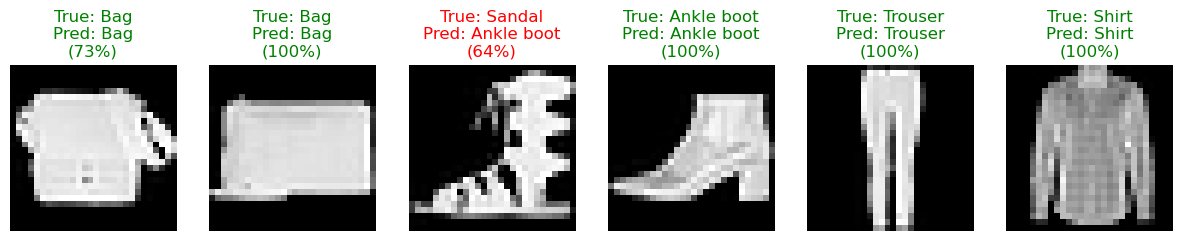

In [61]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

final_model.eval()

dataiter = iter(valid_loader)
images, labels = next(dataiter)

images = images.cuda()
labels = labels.cuda()

with torch.no_grad():
    logits = final_model(images)
    probs = F.softmax(logits, dim=1)
    max_probs, preds = torch.max(probs, dim=1)

fig, axs = plt.subplots(1, 6, figsize=(15, 6))

for i in range(6):

    img_display = images[i].cpu().squeeze().numpy()
    
    true_label = class_names[labels[i].item()]
    pred_label = class_names[preds[i].item()]
    confidence = max_probs[i].item()
    
    color = 'green' if true_label == pred_label else 'red'
    
    axs[i].imshow(img_display, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'True: {true_label}\nPred: {pred_label}\n({confidence:.0%})', color=color)

plt.show()

In [62]:
torch.save(model, "My_fashion_mnist.pt")

In [63]:
loaded_model = torch.load("My_fashion_mnist.pt", weights_only = False)

# By assigning weight_only as false we can load the full model not just parameters

In [64]:
loaded_model.eval()

ImageClassifier(
  (mlp): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=300, bias=True)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [71]:
torch.save(model.state_dict(), "my_fashion_mnist_weights.pt")
#better than before due to security reasons and only provides the parameters used in model trained

In [72]:
new_model = ImageClassifier(n_inputs = 1 * 28 * 28, n_hidden1 = 300, n_hidden2 = 100, n_classes = 10)

In [73]:
loaded_weights = torch.load("my_fashion_mnist_weights.pt", weights_only = True)

In [74]:
new_model.load_state_dict(loaded_weights)

# After creating the same class as the model inside we then loaded the weight used to train the model

<All keys matched successfully>

In [75]:
new_model.eval()

ImageClassifier(
  (mlp): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=300, bias=True)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [76]:
torchscript_model = torch.jit.trace(model, X_new)

# converting the model into torchscript enable it to use in every environment
# But this conversion doesnt helps in conditions like if or match where it only execute the working lines

In [77]:
torchscript_model = torch.jit.script(model)

optimized_model = torch.jit.optimize_for_inference(torchscript_model)

In [79]:
torchscript_model.save("my_fashion_torchscript.pt")
                       

In [81]:
loaded_torchscript_model = torch.jit.load("my_fashion_torchscript.pt")

compiled_model = torch.compile(model)

In [82]:
compiled_model = torch.compile(model)